# Difference-in-Differences Analysis Example

This notebook demonstrates how to use the restructured causal inference library for a comprehensive DiD analysis.

## Overview
Difference-in-Differences (DiD) is a quasi-experimental design that compares the changes in outcomes over time between a treatment group and a control group.

In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the parent directory to the path so we can import our library
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

from causal_inference.methods import DifferenceInDifferences
from causal_inference.datasets import generate_did_data
from causal_inference.utils import validate_panel_data

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Generate Synthetic Data

We'll start by generating synthetic data that mimics a typical DiD setup.

In [2]:
# Generate synthetic data
print("Generating synthetic DiD data...")
data = generate_did_data(
    n_units=100,           # 100 units (e.g., stores, individuals)
    n_periods=10,          # 10 time periods
    treatment_period=6,    # Treatment starts in period 6
    treatment_effect=2.5,  # True treatment effect
    noise_std=1.0,         # Standard deviation of noise
    random_seed=42         # For reproducibility
)

print(f"Generated data with {len(data)} observations")
print(f"Data shape: {data.shape}")
print("\nFirst few rows:")
data.head(10)

Generating synthetic DiD data...
Generated data with 1000 observations
Data shape: (1000, 5)

First few rows:


,unit_id,period,treated,post,outcome
0,1,1,1,0,1.371343
1,1,2,1,0,3.320693
2,1,3,1,0,2.639747
3,1,4,1,0,1.584320
4,1,5,1,0,1.328921
5,1,6,1,1,2.014733
6,1,7,1,1,5.031346
7,1,8,1,1,4.792749
8,1,9,1,1,3.199792
9,1,10,1,1,5.279969


## 2. Data Validation

Before running the analysis, let's validate our data structure.

In [3]:
# Validate the panel data structure
validation_results = validate_panel_data(
    data, 
    unit_var='unit_id', 
    time_var='period',
    outcome_var='outcome', 
    treatment_var='treated'
)

print("\nData validation results:")
for key, value in validation_results.items():
    print(f"  {key}: {value}")

✓ Data validation completed:
  Units: 100 (Treatment: 50, Control: 50)
  Time periods: 10
  Panel balance: Balanced
  Completeness: 100.0%

Data validation results:
  n_units: 100
  n_periods: 10
  expected_observations: 1000
  actual_observations: 1000
  is_balanced: True
  completeness_rate: 1.0
  treatment_units: 50
  control_units: 50
  treatment_share: 0.5


## 3. Initialize DiD Estimator

Now let's initialize our DiD estimator with the data.

In [4]:
# Initialize DiD estimator
print("Initializing DiD estimator...")
did = DifferenceInDifferences(
    data=data,
    outcome_var='outcome',
    unit_var='unit_id',
    time_var='period',
    treatment_var='treated',
    post_var='post',
    treatment_start=6
)

print("\nDiD estimator initialized successfully!")

Initializing DiD estimator...
✓ Data validation passed
  - Units: 100
  - Time periods: 10
  - Treatment units: 50
  - Control units: 50

DiD estimator initialized successfully!


## 4. Basic DiD Estimation

Let's start with the basic 2x2 DiD estimation using group means.

In [5]:
# Run basic DiD estimation
basic_results = did.estimate_basic_did()

print("\nBasic DiD Results Summary:")
print(f"True treatment effect: 2.5")
print(f"Estimated treatment effect: {basic_results['did_estimate']:.3f}")
print(f"Estimation error: {abs(basic_results['did_estimate'] - 2.5):.3f}")


BASIC DiD ESTIMATION (2x2 Design)
Group means:
  Control - Pre: 0.77
  Control - Post: 1.43
  Treatment - Pre: -0.02
  Treatment - Post: 3.29

Differences:
  Control group change: 0.65
  Treatment group change: 3.31
  DiD estimate: 2.65

Basic DiD Results Summary:
True treatment effect: 2.5
Estimated treatment effect: 2.654
Estimation error: 0.154


## 5. Regression-Based DiD

Now let's run the regression-based DiD estimation which provides standard errors and statistical tests.

In [6]:
# Run regression-based DiD estimation
regression_results = did.estimate_regression_did(robust_se=True)

print("\nRegression DiD Results:")
print(f"Coefficient: {regression_results['did_coefficient']:.3f}")
print(f"Standard Error: {regression_results['model'].bse['did_term']:.3f}")
print(f"P-value: {regression_results['did_pvalue']:.4f}")
print(f"95% CI: [{regression_results['did_confidence_interval'][0]:.3f}, {regression_results['did_confidence_interval'][1]:.3f}]")


REGRESSION-BASED DiD ESTIMATION
Regression results:
  Intercept (Control, Pre): 0.77
  Treatment Group Effect: -0.79
  Post Period Effect: 0.65
  DiD Effect: 2.65
  p-value: 0.0000
  95% CI: [2.09, 3.22]
  R²: 0.224
✓ STATISTICALLY SIGNIFICANT at 5% level

Regression DiD Results:
Coefficient: 2.654
Standard Error: 0.289
P-value: 0.0000
95% CI: [2.088, 3.221]


## 6. Assumption Checks

DiD relies on several key assumptions. Let's check them systematically.

### 6.1 Parallel Trends Assumption


ASSUMPTION CHECK: PARALLEL TRENDS
Pre-treatment trends:
  Treatment group slope: 0.242 (p-value: 0.280)
  Control group slope: 0.232 (p-value: 0.238)
  Difference in slopes: 0.010
  Statistical test p-value: 0.943
✓ PARALLEL TRENDS: ASSUMPTION SATISFIED (p > 0.05)


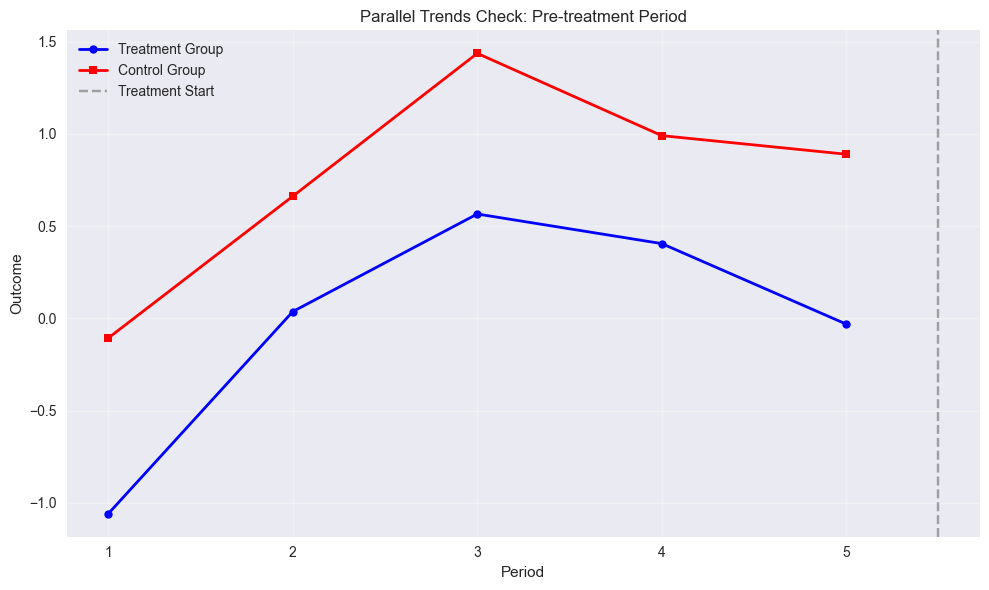


Parallel Trends Test:
Treatment group slope: 0.242
Control group slope: 0.232
Statistical test p-value: 0.943
Assumption satisfied: True


In [7]:
# Check parallel trends assumption
parallel_trends = did.check_parallel_trends(plot=True)

print(f"\nParallel Trends Test:")
print(f"Treatment group slope: {parallel_trends['treatment_slope']:.3f}")
print(f"Control group slope: {parallel_trends['control_slope']:.3f}")
print(f"Statistical test p-value: {parallel_trends['trend_test_pvalue']:.3f}")
print(f"Assumption satisfied: {parallel_trends['assumption_satisfied']}")

### 6.2 Common Shocks Assumption

In [8]:
# Check for differential shocks
common_shocks = did.check_common_shocks()

print(f"\nCommon Shocks Test:")
print(f"Treatment volatility: {common_shocks['treatment_volatility']:.4f}")
print(f"Control volatility: {common_shocks['control_volatility']:.4f}")
print(f"Levene's test p-value: {common_shocks['levene_pvalue']:.3f}")
print(f"Assumption satisfied: {common_shocks['assumption_satisfied']}")


ASSUMPTION CHECK: NO DIFFERENTIAL SHOCKS
Volatility comparison:
  Treatment group volatility: 15.7040
  Control group volatility: 27.6206
  Ratio: 0.57
  Levene's test p-value: 0.657
✓ COMMON SHOCKS: ASSUMPTION SATISFIED

Common Shocks Test:
Treatment volatility: 15.7040
Control volatility: 27.6206
Levene's test p-value: 0.657
Assumption satisfied: True


### 6.3 Composition Stability

In [9]:
# Check composition stability
composition = did.check_composition_stability()

print(f"\nComposition Stability:")
print(f"Total units: {composition['total_units']}")
print(f"Balanced panel: {composition['is_balanced']}")
print(f"Completeness rate: {composition['completeness_rate']:.2%}")
print(f"Assumption satisfied: {composition['assumption_satisfied']}")


ASSUMPTION CHECK: STABLE COMPOSITION
Composition analysis:
  Total units: 100
  Units per period range: 100 - 100
  Completeness rate: 100.00%
✓ COMPOSITION STABILITY: BALANCED PANEL

Composition Stability:
Total units: 100
Balanced panel: True
Completeness rate: 100.00%
Assumption satisfied: True


## 7. Robustness Checks

Let's run some robustness checks to validate our findings.

### 7.1 Placebo Test

In [10]:
# Run placebo test
placebo_results = did.placebo_test()

print(f"\nPlacebo Test:")
print(f"Fake treatment time: {placebo_results['fake_treatment_time']}")
print(f"Placebo coefficient: {placebo_results['placebo_coefficient']:.3f}")
print(f"P-value: {placebo_results['placebo_pvalue']:.4f}")
print(f"Test passed: {placebo_results['test_passed']}")


ROBUSTNESS CHECK: PLACEBO TEST
Placebo test (fake treatment at 3.0):
  Placebo DiD coefficient: -0.00
  p-value: 0.9929
✓ PLACEBO TEST PASSED (no false positive)

Placebo Test:
Fake treatment time: 3.0
Placebo coefficient: -0.004
P-value: 0.9929
Test passed: True


## 8. Complete Analysis Summary

Let's get a comprehensive summary of our analysis.

In [11]:
# Print comprehensive summary
did.print_summary()

# Also show the summary method from the base class
print("\n" + "="*50)
print("FORMATTED SUMMARY")
print("="*50)
print(did.summary())


ANALYSIS SUMMARY
Assumption Checks:
  Parallel Trends: ✓ PASSED
  Common Shocks: ✓ PASSED
  Composition Stability: ✓ PASSED

DiD Estimates:
  Basic DiD: 2.65
  Regression DiD: 2.65 (p=0.000)

Robustness Checks:
  Placebo Test: ✓ PASSED

FORMATTED SUMMARY
Difference-in-Differences Estimation Results
DiD Estimate: 2.654
Treatment Group Change: 3.308
Control Group Change: 0.654


## 9. Accessing Results Programmatically

All results are stored and can be accessed programmatically for further analysis.

In [12]:
# Access results programmatically
print("Programmatic access to results:")
print(f"Basic DiD estimate: {basic_results['did_estimate']:.3f}")
print(f"Regression DiD estimate: {regression_results['did_coefficient']:.3f}")
print(f"Regression p-value: {regression_results['did_pvalue']:.4f}")
print(f"R-squared: {regression_results['r_squared']:.3f}")

# Access all stored results
all_results = did.get_results()
print(f"\nAvailable result keys: {list(all_results.keys())}")

Programmatic access to results:
Basic DiD estimate: 2.654
Regression DiD estimate: 2.654
Regression p-value: 0.0000
R-squared: 0.224

Available result keys: ['basic_did', 'regression_did', 'placebo_test']


## 10. Conclusion

This example demonstrated:

1. **Data Generation**: Using synthetic data that mimics real-world scenarios
2. **Data Validation**: Ensuring data quality before analysis
3. **Multiple Estimation Methods**: Basic and regression-based DiD
4. **Assumption Testing**: Systematic checks of DiD assumptions
5. **Robustness Checks**: Placebo tests to validate findings
6. **Result Access**: Both human-readable summaries and programmatic access

The new library structure provides:
- **Modularity**: Clear separation of concerns
- **Extensibility**: Easy to add new methods
- **Reliability**: Comprehensive testing and validation
- **Usability**: Both interactive and programmatic interfaces

### Next Steps
- Try with your own data
- Explore other methods (PSM, RDD)
- Add custom covariates and controls
- Experiment with different specifications